In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, random_split
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import func, create_engine
from collections import Counter
from PIL import Image
from io import BytesIO
from backend.db_setup import BirdImage

# Configuration du dispositif
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Charger la base de données
DATABASE_URL = "sqlite:///./bird_data.db"
engine = create_engine(DATABASE_URL, connect_args={"check_same_thread": False})
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
db = SessionLocal()

# Définir la fonction pour obtenir les 10 classes les plus représentées
def get_top_classes(db: Session, top_n=10):
    class_counts = db.query(BirdImage.class_label, func.count(BirdImage.class_label)).group_by(BirdImage.class_label).all()
    sorted_classes = sorted(class_counts, key=lambda x: x[1], reverse=True)[:top_n]
    top_classes = [cls for cls, _ in sorted_classes]
    return top_classes

# Filtrer les classes avec le plus d'images
top_classes = get_top_classes(db, top_n=10)

# Créer un Dataset personnalisé pour les images
class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, samples, class_to_idx, transform=None):
        self.samples = samples
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_data, label = self.samples[idx]
        
        # Charger l'image depuis les données binaires
        image = Image.open(BytesIO(image_data)).convert('RGB')
        
        # Appliquer les transformations si elles sont définies
        if self.transform:
            image = self.transform(image)
        
        # Convertir l'étiquette en un indice numérique
        label_idx = self.class_to_idx[label]
        
        # Retourner l'image et l'étiquette sous forme de Tensor
        return image, label_idx

# Créer un mappage des étiquettes (chaînes) vers des indices numériques
class_to_idx = {cls: idx for idx, cls in enumerate(top_classes)}

# Transformations avec augmentation des données
transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger les samples depuis la base de données
samples = []
for bird_image in db.query(BirdImage).filter(BirdImage.class_label.in_(top_classes)).all():
    samples.append((bird_image.image, bird_image.class_label))

# Créer le dataset filtré
filtered_dataset = FilteredDataset(samples, class_to_idx, transform)

# Division des données en ensembles d'entraînement, validation et test
train_size = int(0.7 * len(filtered_dataset))
val_size = int(0.15 * len(filtered_dataset))
test_size = len(filtered_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(filtered_dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
}

# Charger MobileNetV2 avec fine-tuning
model = mobilenet_v2(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.last_channel, len(top_classes))
model = model.to(device)

# Optimisation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Fonction d'entraînement avec diagnostic
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        model.train()

        running_loss = 0.0
        running_corrects = 0

        # Phase d'entraînement
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Phase de validation après chaque époque
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += (outputs.argmax(1) == labels).sum().item()

        val_loss = val_loss / len(dataloaders['val'].dataset)
        val_acc = val_corrects / len(dataloaders['val'].dataset)
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()
    return model

# Fonction d'évaluation
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Entraîner le modèle
model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10)

# Évaluer sur le test
test_acc = evaluate_model(model, dataloaders['test'])
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
----------
Train Loss: 1.6533 Acc: 0.4429
Val Loss: 1.4540 Acc: 0.5111
Epoch 2/10
----------
Train Loss: 1.0362 Acc: 0.6595
Val Loss: 1.2104 Acc: 0.6556
Epoch 3/10
----------
Train Loss: 0.8861 Acc: 0.6905
Val Loss: 0.8944 Acc: 0.7222
Epoch 4/10
----------
Train Loss: 0.7659 Acc: 0.7476
Val Loss: 1.0584 Acc: 0.6444
Epoch 5/10
----------
Train Loss: 0.7261 Acc: 0.7595
Val Loss: 1.0088 Acc: 0.6444
Epoch 6/10
----------
Train Loss: 0.6896 Acc: 0.7571
Val Loss: 1.0584 Acc: 0.7000
Epoch 7/10
----------
Train Loss: 0.7340 Acc: 0.7524
Val Loss: 1.0337 Acc: 0.7000
Epoch 8/10
----------
Train Loss: 0.6880 Acc: 0.7833
Val Loss: 1.0317 Acc: 0.6222
Epoch 9/10
----------
Train Loss: 0.5906 Acc: 0.8071
Val Loss: 0.9164 Acc: 0.6556
Epoch 10/10
----------
Train Loss: 0.4668 Acc: 0.8429
Val Loss: 0.8436 Acc: 0.7222
Test Accuracy: 0.6556


In [7]:
import torch
from torchvision import models
import torch.nn as nn

# Initialize MobileNetV2
num_classes = 10  # Modify to match your number of classes
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier layer for your specific problem (10 output classes)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

# Save the model state dictionary
torch.save(model.state_dict(), "bird_classifier.pth")
print("Model saved as 'bird_classifier.pth'")

# Loading the model (ensure it has the same architecture)
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

# Load the saved weights
model.load_state_dict(torch.load("bird_classifier.pth"))
model.eval()  # Set the model to evaluation mode


Model saved as 'bird_classifier.pth'


C:\Users\paulj\AppData\Local\Temp\ipykernel_11444\1484499617.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bird_classifier.pth"))


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
import torch

# Charger le fichier de sauvegarde du modèle
model_checkpoint = "bird_classifier.pth"
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))

# Récupérer le mapping des classes
if 'class_to_idx' in checkpoint:
    class_to_idx = checkpoint['class_to_idx']
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Inverser le dictionnaire
    print("Indices et classes :", idx_to_class)
else:
    print("Le mapping 'class_to_idx' n'est pas présent dans le fichier du modèle.")


Le mapping 'class_to_idx' n'est pas présent dans le fichier du modèle.


C:\Users\paulj\AppData\Local\Temp\ipykernel_11444\3383157091.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint, map_location=torch

In [9]:
for idx, class_name in enumerate(top_classes):
    print(f"Classe {idx}: {class_name}")


Classe 0: 001.Black_footed_Albatross
Classe 1: 002.Laysan_Albatross
Classe 2: 004.Groove_billed_Ani
Classe 3: 010.Red_winged_Blackbird
Classe 4: 011.Rusty_Blackbird
Classe 5: 013.Bobolink
Classe 6: 014.Indigo_Bunting
Classe 7: 021.Eastern_Towhee
Classe 8: 025.Pelagic_Cormorant
Classe 9: 026.Bronzed_Cowbird


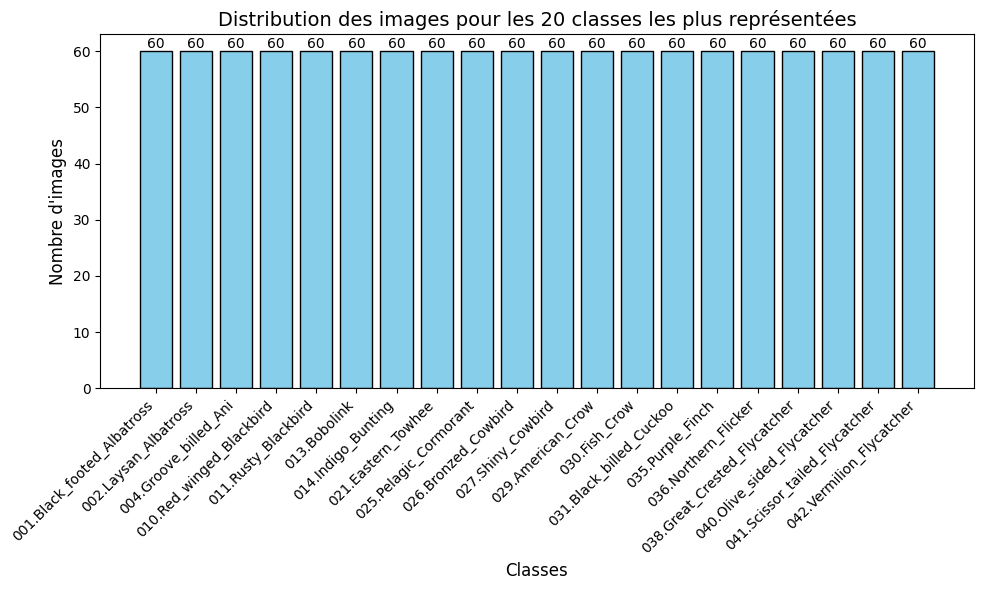

Classe la plus représentée : 001.Black_footed_Albatross


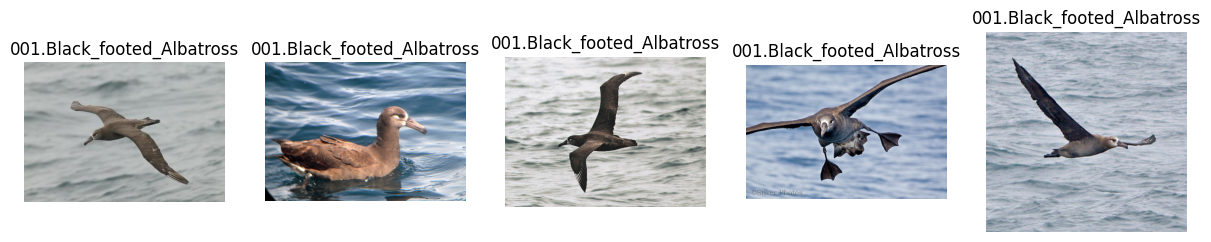

Classe la moins représentée : 006.Least_Auklet


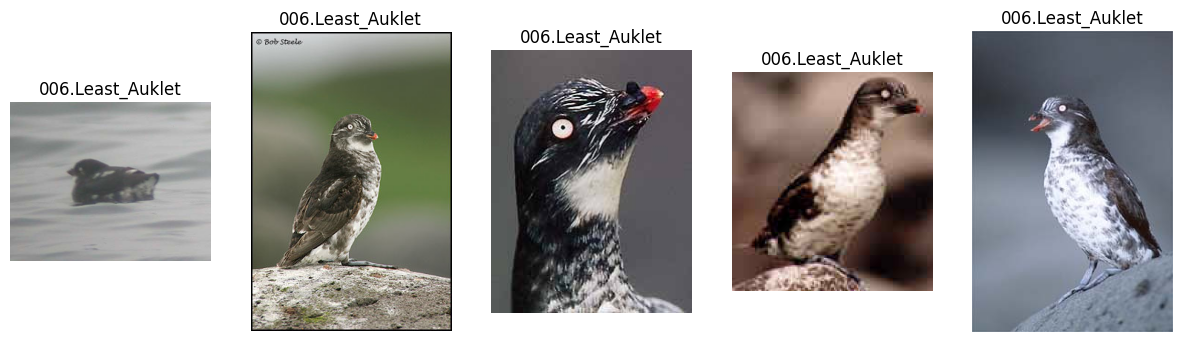

In [13]:
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from PIL import Image
from io import BytesIO
import numpy as np

# Charger la base de données
db = SessionLocal()

# Récupérer la distribution des classes
def get_class_distribution(db: Session):
    class_counts = db.query(BirdImage.class_label, func.count(BirdImage.class_label)).group_by(BirdImage.class_label).all()
    return dict(class_counts)

def plot_class_distribution(class_distribution, top_n=20):
    # Trier les classes par nombre d'images, et ne garder que les `top_n` classes
    sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)[:top_n]
    classes, counts = zip(*sorted_classes)

    # Taille et style du graphique
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')

    # Ajouter les valeurs au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)

    # Ajuster l'affichage
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotation des étiquettes des classes
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Nombre d'images", fontsize=12)
    plt.title(f"Distribution des images pour les {top_n} classes les plus représentées", fontsize=14)
    plt.tight_layout()  # Ajuster automatiquement les marges
    plt.show()



# Afficher quelques images par classe
def show_images_by_class(db: Session, class_label, num_images=5):
    images = db.query(BirdImage.image).filter(BirdImage.class_label == class_label).limit(num_images).all()
    if not images:
        print(f"Aucune image trouvée pour la classe {class_label}")
        return

    plt.figure(figsize=(15, 5))
    for idx, (image_data,) in enumerate(images):
        image = Image.open(BytesIO(image_data)).convert('RGB')
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(np.asarray(image))
        plt.axis('off')
        plt.title(class_label)
    plt.show()

# Afficher les 20 classes les plus représentées
plot_class_distribution(class_distribution, top_n=20)

# Afficher quelques images d'une classe
top_class = max(class_distribution, key=class_distribution.get)
print(f"Classe la plus représentée : {top_class}")
show_images_by_class(db, top_class)

# Classe moins représentée
least_class = min(class_distribution, key=class_distribution.get)
print(f"Classe la moins représentée : {least_class}")
show_images_by_class(db, least_class)
